In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import re
import math
import functools
import traceback
import seaborn as sb
import matplotlib.pyplot as plt
import anndata
import scanpy as sc
import spatialdata_plot
import numpy as np
import pandas as pd
import corescpy as cr

# Main
write_object = True  # change to True when you're ready to save objects
overwrite = False  # overwrite if already exists?
col_cell_type = "leiden_res1pt5_dist0_npc30"
col_ann = "Bucket"
regions = ["mucosa", "serosa", "myenteric_plexus",
           "submucosa", "smc_circular", "smc_longitudinal"]

# Process Options
panel = "TUQ97N"  # Xenium panel ID
constants_dict = cr.get_panel_constants(panel_id=panel)
libs = [  # sample IDs from patients for whom we have all conditions
    "50452A", "50452B", "50452C",  # old segmentation
    "50006A", "50006B", "50006C",  # rest are new segmentation
    "50217A", "50217B", "50217C",
    "50336B", "50336C", "50336A",
    "50403A2", "50403B", "50403C1"
]  # excludes low-quality sample/condition replicates 50403A1 & 50403C2
# libs = None  # to run all available samples
cols = [
    "transcript_counts", "cell_area", "nucleus_area", "nucleus_count",
    "control_probe_counts", "control_codeword_counts",
    "unassigned_codeword_counts", "deprecated_codeword_counts"
]
# cols_plot = list(cols)
cols_plot = ["transcript_counts", "cell_area", "nucleus_area",
             "nucleus_count", "control_probe_counts"]
input_suffix = ""  # in case want to load objects with some suffix

# Files & Directories
direc = "/mnt/cho_lab/bbdata2/"  # mounted NFS with data
dir_entry = "/mnt/cho_lab/disk2"  # Spark writeable data directory
mdf = str("/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/samples_"
          f"{panel}.csv")  # metadata file path (for now; will soon be on NFS)
dir_writeable = os.path.join(
    dir_entry, f"elizabeth/data/shared-xenium-library")  # where objects are
out_dir = os.path.join(
    dir_writeable, f"outputs/{panel}/nebraska")  # object output directory

#  Your Folders
out_new = os.path.join(
    dir_entry,
    f"{os.getlogin()}/data/shared-xenium-library/outputs/{panel}/nebraska")

# Constants (Shouldn't Need Edits Unless Extreme Process Changes)
cso, col_sample, col_condition, col_inflamed, col_subject = [
    constants_dict[x] if x in constants_dict else None for x in [
        "col_sample_id_o", "col_sample_id", "col_condition",
        "col_inflamed", "col_subject"]]
dir_data = os.path.join(direc, f"outputs/{panel}")
files = functools.reduce(lambda i, j: i + j, [[os.path.join(
    run, i) for i in os.listdir(os.path.join(
        dir_data, run))] for run in os.listdir(dir_data)])  # all data paths
os.makedirs(out_dir, exist_ok=True)  # make output directory if needed
metadata = cr.pp.get_metadata_cho(direc, mdf, panel_id=panel, samples=libs)
f_ann = pd.read_excel(os.path.join(
    out_dir, "annotation_dictionaries/annotations_all.xlsx"), index_col=[
        0, 1]).dropna(how="all").dropna(how="all", axis=1)
f_ann = f_ann.reset_index().astype({f_ann.index.names[1]: "int"}).astype({
    f_ann.index.names[1]: "string"}).set_index(f_ann.index.names)
metadata[col_subject]

ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

Sample
Uninflamed-50452A     50452
Inflamed-50452B       50452
Stricture-50452C      50452
Inflamed-50006A       50006
Uninflamed-50006B     50006
Stricture-50006C      50006
Inflamed-50217A       50217
Uninflamed-50217B     50217
Stricture-50217C      50217
Inflamed-50336B       50336
Uninflamed-50336C     50336
Stricture-50336A      50336
Uninflamed-50403A2    50403
Inflamed-50403B       50403
Stricture-50403C1     50403
Name: subject_id, dtype: int64

# Overall Cell Counts & Metadata

In [2]:
n_origin, n_proc, obs = {}, {}, {}
for s in libs:  # iterate samples
    print(f"\n\n{'=' * 80}\n{s}\n{'=' * 80}\n\n")
    fff = os.path.join(dir_data, np.array(files)[np.where([
        s == os.path.basename(x).split("__")[2].split("-")[0]
        for x in files])[0][0]])  # sample's Xenium data directory path
    lib = metadata.reset_index().set_index(cso).loc[s][col_sample]
    file_obj_proc = os.path.join(out_dir, f"{lib}{input_suffix}.h5ad")
    self = cr.Spatial(fff, library_id=lib)  # load original data
    adata = sc.read_h5ad(file_obj_proc)  # processed adata
    n_origin[s], n_proc[s] = self.rna.obs.shape[0], adata.obs.shape[0]
    obs[s] = adata.obs[adata.obs.columns.intersection(set(cols + [
        col_cell_type]))].groupby(col_cell_type).describe().copy()
    sb.pairplot(adata.obs[adata.obs.columns.intersection(set(cols))])
n_cells = pd.concat([pd.Series(x, index=pd.Index(libs, name=cso))
                     for x in [n_origin, n_proc]],
                    keys=["Original", "Processed"], names=["Source"], axis=1)
n_cells = n_cells.assign(Percent=100 * n_cells["Processed"] / n_cells[
    "Original"])  # percent of cells remaining after processing
obs = pd.concat(obs, keys=libs, names=[cso])



50452A




<<< INITIALIZING SPATIAL CLASS OBJECT >>>

INFO     reading                                                                                                   
         /mnt/cho_lab/bbdata2/outputs/TUQ97N/CHO-001/output-XETG00189__0010700__50452A-TUQ97N-EA__20240126__205019/
         cell_feature_matrix.h5                                                                                    


Counts: Initial: table


	Observations: 333825

	Genes: 469







 AnnData object with n_obs × n_vars = 333825 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'cell_labels', 'Sample'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs', 'spatial', 'original_ix'
    obsm: 'spatial'
    layers: 'counts' 

                      gene_ids    feature_types   genome
gene_symbols                               

## Write

In [ ]:
# n_cells.to_csv(os.path.join(
#     out_new, f"quantification/xenium_n_cells{input_suffix}.csv"))
# obs.to_csv(os.path.join(
#     out_new, f"quantification/xenium_qc{input_suffix}.csv"))

## Reload

In [6]:
# n_cells = pd.read_csv(os.path.join(
#     out_new, f"quantification/xenium_n_cells{input_suffix}.csv"),
#                       index_col=0)
# obs = pd.read_csv(os.path.join(
#     out_new, f"quantification/xenium_qc{input_suffix}.csv"),
#                   header=[0, 1], index_col=[0, 1]).rename_axis([
#                       "Variable", "Metric"], axis=1).stack(0)

# Inspect

In [9]:
n_cells

,Original,Processed
sample_id,,
50452A,333825,312629
50452B,276881,257679
50452C,613026,589419
50006A,297656,220569
50006B,116837,78976
50006C,721489,599115
50217A,1038830,972278
50217B,814930,773732
50217C,860665,805650


In [10]:
obs

Metric                                                             count  \
sample_id leiden_res1pt5_dist0_npc30 Variable                              
50452A    0                          cell_area                   23746.0   
                                     control_codeword_counts     23746.0   
                                     control_probe_counts        23746.0   
                                     deprecated_codeword_counts  23746.0   
                                     nucleus_area                23746.0   
...                                                                  ...   
50403C1   34                         nucleus_area                  316.0   
                                     nucleus_count                 322.0   
                                     total_counts                  322.0   
                                     transcript_counts             322.0   
                                     unassigned_codeword_counts    322.0   

Metric                                                                 mean  \
sample_id leiden_res1pt5_dist0_npc30 Variable                                 
50452A    0                          cell_area                   153.547809   
                                     control_codeword_counts       0.014613   
                                     control_probe_counts          0.003327   
                                     deprecated_codeword_counts    0.000000   
                                     nucleus_area                 31.495240   
...                                                                     ...   
50403C1   34                         nucleus_area                 21.739591   
                                     nucleus_count                 1.009317   
                                     total_counts                 29.472050   
                                     transcript_counts            29.472050   
                                     unassigned_codeword_counts    0.000000   

Metric                                                                 std  \
sample_id leiden_res1pt5_dist0_npc30 Variable                                
50452A    0                          cell_area                   97.326127   
                                     control_codeword_counts      0.122088   
                                     control_probe_counts         0.057584   
                                     deprecated_codeword_counts   0.000000   
                                     nucleus_area                16.263348   
...                                                                    ...   
50403C1   34                         nucleus_area                10.702133   
                                     nucleus_count                0.215967   
                                     total_counts                12.268066   
                                     transcript_counts           12.268066   
                                     unassigned_codeword_counts   0.000000   

Metric                                                                 min  \
sample_id leiden_res1pt5_dist0_npc30 Variable                                
50452A    0                          cell_area                   18.785001   
                                     control_codeword_counts      0.000000   
                                     control_probe_counts         0.000000   
                                     deprecated_codeword_counts   0.000000   
                                     nucleus_area                 3.838281   
...                                                                    ...   
50403C1   34                         nucleus_area                 4.289844   
                                     nucleus_count                0.000000   
                                     total_counts                15.000000   
                                     transcript_counts           15.000000   
                                

## Plot

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

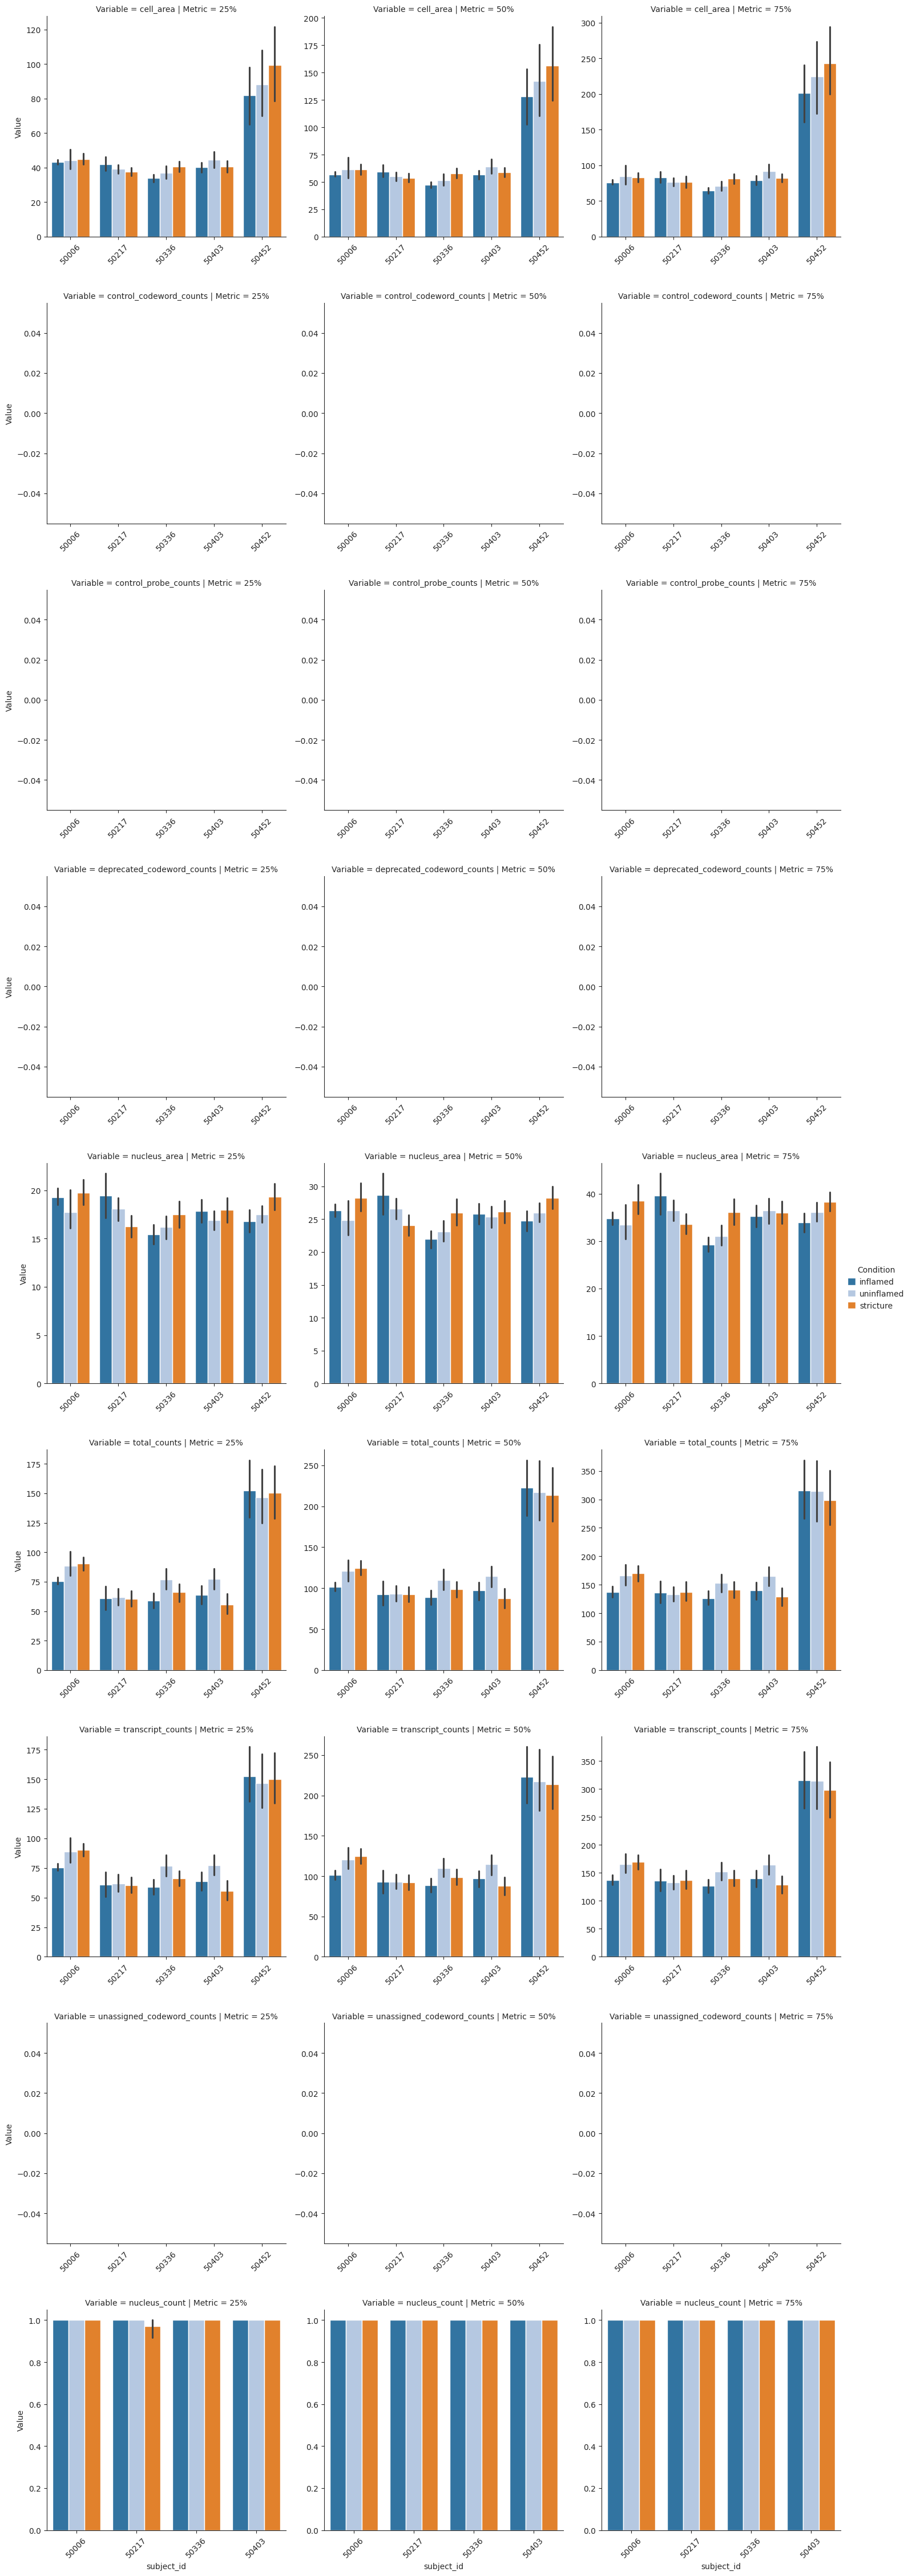

In [11]:
palette = "tab20"
# palette = ["r", "b", "y"]

fig = sb.catplot(obs[["25%", "50%", "75%"]].stack().to_frame("Value").join(
    metadata.reset_index().set_index(cso)), x=col_subject, y="Value",
                 row="Variable", col="Metric", kind="bar", hue=col_condition,
                 sharex=False, sharey=False, palette=palette)
fig.set_xticklabels(rotation=45, fontsize=10)
plt.subplots_adjust(hspace=0.3)

# By Region

In [16]:
adata.obs.columns

Index(['cell_id', 'transcript_counts', 'control_probe_counts',
       'control_codeword_counts', 'unassigned_codeword_counts',
       'deprecated_codeword_counts', 'total_counts', 'cell_area',
       'nucleus_area', 'region', 'Sample', 'sample_id', 'subject_id', 'run_id',
       'panel_id', 'slide_id', 'clinical_block', 'description',
       'date_hybridization', 'date_sectioned', 'location', 'inflammation',
       'stricture', 'Condition', 'tissue_region_crop', 'Age', 'Diagnosis',
       'Disease_Status', 'Hispanic', 'Race', 'Sex', 'Unnamed: 29',
       'assay_protein', 'cell_filter_ncounts', 'cell_filter_ngene',
       'cell_filter_pmt', 'cell_labels', 'col_batch', 'col_cell_type',
       'col_condition', 'col_gene_symbols', 'col_num_umis', 'col_sample_id',
       'col_segment', 'col_subject', 'custom_thresholds', 'figsize',
       'file_path', 'gene_filter_ncell', 'gene_filter_ncounts', 'kws_scale',
       'label_res1pt5_dist0_npc30', 'leiden_res1pt5_dist0_npc30',
       'log1p_n_ge

In [29]:
col_cell_type = "leiden_res1pt5_dist0_npc30"

obs_reg, n_cells_reg = {},{}
for r in regions:
    obs_reg[r], n_cells_reg[r] = {},{}
    for s in libs:  # iterate samples
        print(f"\n\n{'=' * 80}\n{s}\n{'=' * 80}\n\n")
        fff = os.path.join(dir_data, np.array(files)[np.where([
            s == os.path.basename(x).split("__")[2].split("-")[0]
            for x in files])[0][0]])  # sample's Xenium data directory path
        lib = metadata.reset_index().set_index(cso).loc[s][col_sample]
        file_obj_proc = os.path.join(out_dir, "objects_cropped",
                                     r, f"{lib}_{r}{input_suffix}.h5ad")
        if not os.path.exists(file_obj_proc):
            print(f"{file_obj_proc} doesn't exist")
            continue
        adata = sc.read_h5ad(file_obj_proc)  # processed adata
        obs_reg[r][s] = adata.obs[adata.obs.columns.intersection(set(cols + [
            col_cell_type]))].assign(n_cells=adata.obs.shape[0])
        n_cells_reg[r][s] = adata.obs[col_cell_type].value_counts()
        # adata.obs = adata.obs.join(
        #     adata.obs[col_cell_type].astype(str).map(dict(f_ann.loc[
        #         f"{lib}___{col_cell_type}_dictionary.xlsx"])[
        #             "bucket"]).to_frame("Annotation"),
        #     lsuffix="_original")
        # n_cells_reg[r][s] = adata.obs["Annotation"].value_counts()
    n_cells_reg[r] = pd.concat(n_cells_reg[r], names=[cso])
    obs_reg[r] = pd.concat(obs_reg[r], names=[cso])
obs_reg = pd.concat(obs_reg, names=["Region"])
n_cells_reg = pd.concat(n_cells_reg, names=["Region"])
n_cells_reg = n_cells_reg.to_frame("Count").join(n_cells_reg.groupby([
    "Region", "sample_id"]).sum().to_frame("Total"))
n_cells_reg.loc[:, "Percent"] = 100 * n_cells_reg[
    "Count"] / n_cells_reg["Total"]



50452A


/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/objects_cropped/mucosa/Uninflamed-50452A_mucosa.h5ad doesn't exist


50452B


/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/objects_cropped/mucosa/Inflamed-50452B_mucosa.h5ad doesn't exist


50452C


/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/objects_cropped/mucosa/Stricture-50452C_mucosa.h5ad doesn't exist


50006A




50006B




50006C


/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/objects_cropped/mucosa/Stricture-50006C_mucosa.h5ad doesn't exist


50217A




50217B




50217C


/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/objects_cropped/mucosa/Stricture-50217C_mucosa.h5ad doesn't exist


50336B




50336C




50336A


/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/objects_cropped/mucosa/Stricture-50336A_mucosa.h5ad doesn'

## Write

In [30]:
files = [os.path.join(
    out_new, f"quantification/xenium_qc_{'_'.join(regions)}{input_suffix}"
    ".csv"), os.path.join(
        out_new, f"quantification/xenium_n_cells_{'_'.join(regions)}"
        f"{input_suffix}.csv")]
print(files)
obs_reg.to_csv(files[0])
n_cells_reg.to_csv(files[1])

['/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/quantification/xenium_qc_mucosa_serosa_myenteric_plexus_submucosa_smc_circular_smc_longitudinal_annotation.csv', '/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/quantification/xenium_n_cells_mucosa_serosa_myenteric_plexus_submucosa_smc_circular_smc_longitudinal_annotation.csv']


## Reload

In [28]:
obs_reg = pd.read_csv(os.path.join(
    out_new, f"quantification/xenium_qc_{'_'.join(regions)}{input_suffix}"
    ".csv"), index_col=0)
n_cells_reg = pd.read_csv(os.path.join(
    out_new, f"quantification/xenium_n_cells_{'_'.join(regions)}"
    f"{input_suffix}.csv"), index_col=[0, 1, 2])

## Inspect

In [ ]:
n_cells_reg

Region            sample_id  leiden_res1pt5_dist0_npc30
mucosa            50006A     6                             11415
                             4                              8086
                             5                              7216
                             15                             5472
                             11                             4864
                                                           ...  
smc_longitudinal  50403B     22                               18
                             37                               13
                             16                                7
                             35                                3
                             8                                 1
Name: count, Length: 1610, dtype: int64

In [ ]:
obs_reg

transcript_counts  control_probe_counts  \
Region           sample_id                                                   
mucosa           50006A    1869                  208                     0   
                           1870                  209                     0   
                           1872                  217                     0   
                           1876                   67                     0   
                           1877                   65                     0   
...                                              ...                   ...   
smc_longitudinal 50403B    694024                187                     0   
                           694025                 73                     0   
                           694026                 19                     0   
                           694028                 30                     0   
                           694030                 97                     0   

                                   control_codeword_counts  \
Region           sample_id                                   
mucosa           50006A    1869                          0   
                           1870                          0   
                           1872                          0   
                           1876                          0   
                           1877                          0   
...                                                    ...   
smc_longitudinal 50403B    694024                        0   
                           694025                        0   
                           694026                        0   
                           694028                        0   
                           694030                        0   

                                   unassigned_codeword_counts  \
Region           sample_id                                      
mucosa           50006A    1869                             0   
                           1870                             0   
                           1872                             0   
                           1876                             0   
                           1877                             0   
...                                                       ...   
smc_longitudinal 50403B    694024                           0   
                           694025                           0   
                           694026                           0   
                           694028                           0   
                           694030                           0   

                                   deprecated_codeword_counts   cell_area  \
Region           sample_id                                                  
mucosa           50006A    1869                             0   61.186721   
                           1870                             0   80.965159   
                           1872                             0  110.632817   
                           1876                             0   50.529846   
                           1877                             0   65.025002   
...                                                       ...         ...   
smc_longitudinal 50403B    694024                           0  162.878600   
                           694025                           0   48.452658   
                           694026                           0   15.940157   
                           694028                           0   26.461563   
                           694030                           0   72.340315   

                                   nucleus_area leiden_res1pt5_dist0_npc30  \
Region           sample_id                                                   
mucosa           50006A    1869       39.647189                          7   
                           1870       37.163595                         10   
                           1872       31.338439      

## Plot

## By Region

In [42]:
obs_reg = obs_reg.join(metadata.reset_index().set_index(cso))
n_cells_reg = n_cells_reg.join(metadata.reset_index().set_index(cso))
sb.catplot(n_cells_reg, x=col_cell_type, y="Percent", hue="Region",
           kind="bar", col=col_condition, row=col_subject)
fig = sb.pairplot(obs_reg.reset_index()[cols_plot + ["Region"]], hue="Region",
                  kind="scatter", diag_kind="kde",
                  diag_kws=dict(cut=0, fill=True))

## By Condition & Region

In [ ]:
for r in obs_reg.reset_index().Region.unique():
    fig = sb.pairplot(obs_reg.loc[r][cols_plot], hue=col_condition,
                      kind="scatter", diag_kind="kde",
                      diag_kws=dict(cut=0, fill=True))
    fig.fig.suptitle(r)